In [130]:
!pip install einops
%load_ext autoreload
%autoreload 2

import seaborn as sns
from dataclasses import dataclass
import matplotlib.pyplot as plt

import datautils
from utils import init_dl_program
from hdst import HDST
import torch
import gc
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create Args Configuration Class

In [150]:
@dataclass
class Args:
    task_weights: dict
    dataset: str = ""
    loader: str = ""
    gpu: int = 0
    static_repr_dims: int = 128
    dynamic_repr_dims: int = 128
    epochs: int = 200

    run_name: str = ""
    batch_size: int = 8
    lr: float = 0.001
    max_train_length = 1000
    iters: int = None
    save_every = None
    seed: int = 1234
    max_threads = None
    eval: bool = True
    irregular = 0

    sample_size: int = 3
    window_size: int = None # Use None for multi-scale
    top_k: int =2 # Use the top k prominent periodicity as time scale. If use sepcified window size, you can set top_k as random number.

## Instantiate Args Configuration Class
Create an instance of arguments, specifying the necessary arguments and those important to your use case.

In [151]:
args = Args(
    static_repr_dims=128,
    dynamic_repr_dims=128,
    task_weights={
        'local_static_contrast': 0,
        'global_vatiant_contrast': 0,
        'dynamic_trend_pred': 1,
    },
    eval=False
)

device = init_dl_program(args.gpu, seed=args.seed, max_threads=args.max_threads)

## Load your data
You can use any data, as long as it is an `np.ndarray` of shape $(N, T, C)$ where $N$ is the number of time-series instances, $T$ the number of timesteps per instance, and $C$ the number of channels.
Choosing from 'ETTh1', 'ETTh2', 'ETTm1' and 'ETTm2'

In [152]:
data, train_slice, valid_slice, test_slice, scaler, pred_lens = datautils.load_forecast_csv("ETTm2")
train_data = data[:, train_slice]
test_data = data[:, test_slice]
print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")
print(pred_lens)

Shapes - train data: (1, 34560, 7), test data: (1, 11520, 7)
[24, 48, 96, 288, 672]


In [153]:
from torch.utils.data import TensorDataset, DataLoader
from utils import FFT_for_Period
train_data_temp = (torch.from_numpy(train_data).to(torch.float))
scale_list, scale_weight = FFT_for_Period(train_data_temp, 5)
print(scale_list)

[34560 17280 11520  8640  6912]


## Create and Train the model

In [156]:
sns.set_theme()
torch.cuda.empty_cache()
gc.collect()

6726

In [157]:
import time
start_time = time.time()
model = HDST(
    input_dims=train_data.shape[-1],
    device=device,
    task_weights=args.task_weights,
    batch_size=args.batch_size,
    lr=args.lr,
    output_dims1=args.static_repr_dims,
    output_dims2=args.dynamic_repr_dims,
    max_train_length=args.max_train_length
)

loss_log = model.fit(
    train_data,
    n_epochs=args.epochs,
    n_iters=args.iters,
    k=args.sample_size,
    w=args.window_size,
    top_k=args.top_k
)
end_time = time.time()
training_time = end_time - start_time
print(f"Model training time: {training_time:.2f} seconds")

Training data shape: (34, 1017, 7)
Epoch #0: loss=0.00803236453793943
Epoch #1: loss=0.0020543160499073565
Epoch #2: loss=0.001271721295779571
Epoch #3: loss=0.00092374011001084
Epoch #4: loss=0.0006978638703003526
Epoch #5: loss=0.0005951157218078151
Epoch #6: loss=0.0005062481504864991
Epoch #7: loss=0.0004717708652606234
Epoch #8: loss=0.00042571725498419255
Epoch #9: loss=0.0004004247020930052
Epoch #10: loss=0.00037714678182965145
Epoch #11: loss=0.00036910924973199144
Epoch #12: loss=0.00036141594318905845
Epoch #13: loss=0.0003540970428730361
Epoch #14: loss=0.0003479606893961318
Epoch #15: loss=0.000341700782882981
Epoch #16: loss=0.0003361772105563432
Epoch #17: loss=0.0003259077057009563
Epoch #18: loss=0.0003224086467525922
Epoch #19: loss=0.0003137625826639123
Epoch #20: loss=0.0003109003009740263
Epoch #21: loss=0.00030691357096657157
Epoch #22: loss=0.00030381520627997816
Epoch #23: loss=0.0003022012679139152
Epoch #24: loss=0.00030048000917304307
Epoch #25: loss=0.000300

Save model and loss log

In [158]:
# import torch
# torch.save(model, 'logs/mymodel_ETTh1.pth')
# import pandas as pd
# df = pd.DataFrame({"epoch": list(range(1, len(loss_log) + 1)), "loss": loss_log})
# df.to_csv("logs/loss_log_ETTh1.csv", index=False)

Visualize the loss curve and save figure

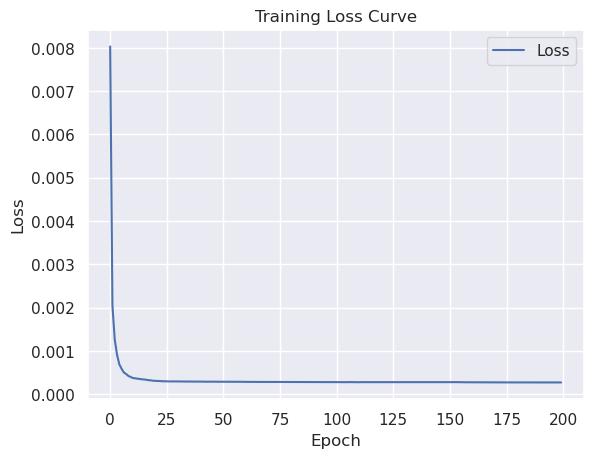

In [159]:
import matplotlib.pyplot as plt
# print(loss_log)
plt.plot(loss_log, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

## Test the model
Firstly, get the representation of training data and test data using `model.encode`. Then train a Ridge regression model using training representation and corresponding training labels. Finally, use the Ridge regression model to do forecasting for test representation. Report the MSE and MAE.

In [160]:
from tasks.forecasting import eval_forecasting
out, eval_res = eval_forecasting(
                model,
                data,
                train_slice,
                valid_slice,
                test_slice,
                scaler,
                pred_lens
            )
res=eval_res['ours']
for key, value in res.items():
    print(f"{key}: {value}")


24: {'norm': {'MSE': 0.16239194138261562, 'MAE': 0.27801932757238434}, 'raw': {'MSE': 9.902333173941859, 'MAE': 2.0917628852705517}}
48: {'norm': {'MSE': 0.24463534915557533, 'MAE': 0.34714122534575587}, 'raw': {'MSE': 16.773181051776405, 'MAE': 2.7056435775915757}}
96: {'norm': {'MSE': 0.31742861942868006, 'MAE': 0.4083297419306173}, 'raw': {'MSE': 22.489173265876367, 'MAE': 3.2332600350638323}}
288: {'norm': {'MSE': 0.7555588395763451, 'MAE': 0.6509816911022063}, 'raw': {'MSE': 54.660284775707645, 'MAE': 5.228367859937217}}
672: {'norm': {'MSE': 2.9215802768996024, 'MAE': 1.3023149830063476}, 'raw': {'MSE': 149.2063898363989, 'MAE': 9.470556958933187}}
